# [HW2 - CNN(Resnet50)medical image analysis]
## skin cancer classification with Resnet50
- author: 김성현(Kim, Seong-Hyun)
- subject: ***생체데이터_기계학습_실습***
- semester: **2024-1, 바이오헬스 혁신공유대학**
- belong: 상명대학교, 휴먼지능정보공학전공 4학년
- student number: 201910783

---


### **- dataset: skin-cancer-mninst-ham10000(kaggle notebook으로 add input하여 사용)**
- 강의자료, 강의교안, 강의코드, 논문 등 참고
- 논문 참고: Learining Deep Features for Discriminative Localization

#### 0. 기본 세팅 진행(라이브러리, 모듈, 데이터셋 등)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
print(os.getcwd())

/kaggle/working


In [3]:
# dataset anaylsis(데이터셋의 정보 및 특성, 구성에 대한 시각화 확인)
#data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
# 1. data head를 통한 metrix 구성 확인
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
# Categories of the different diseases(각 카테고리별 질병 종류)
data_temp = data
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

data_temp.dx=data_temp.dx.astype('category',copy=True)
data_temp['labels']=data_temp.dx.cat.codes # Convert the labels to numbers
data_temp['lesion']= data_temp.dx.map(lesion_type_dict)
data_temp.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,labels,lesion
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,Benign keratosis
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,Benign keratosis
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,Benign keratosis
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,Benign keratosis
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,Benign keratosis


In [5]:
print(data_temp.lesion.value_counts())

lesion
Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


############################################



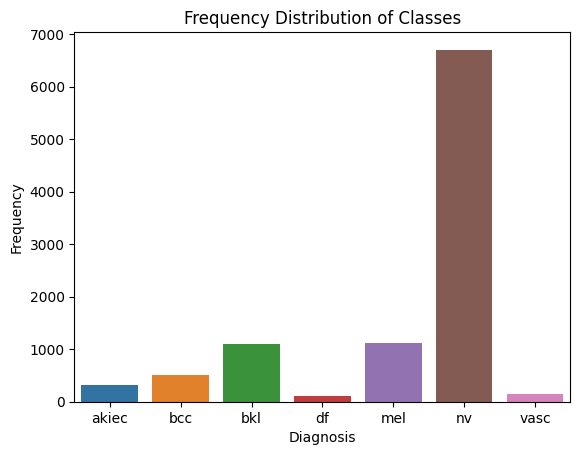

In [6]:
# 2. 각 class별 frequency 확인(frequency를 통한 분포 확인)
sns.countplot(x = 'dx', data = data)
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Classes')
print("############################################\n")

############################################



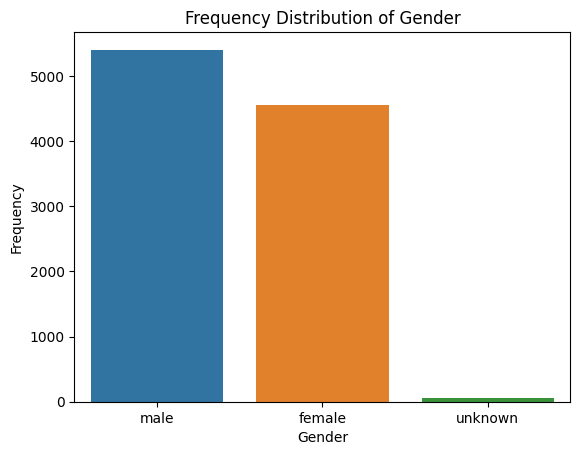

In [7]:
# 3. 각 gender(성별)별 frequency 확인
sns.countplot(x = 'sex', data = data)
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Gender')
print("############################################\n")

############################################



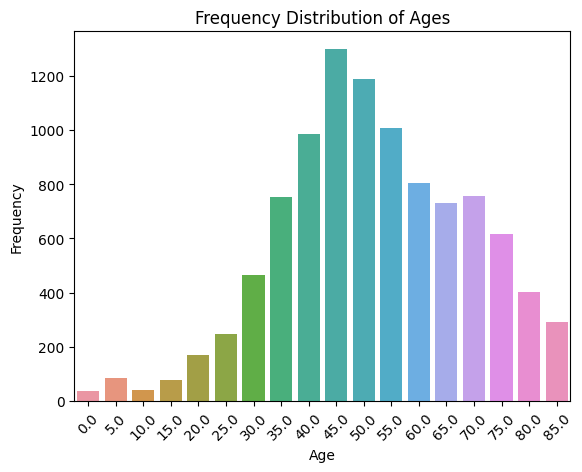

In [8]:
# 4. 각 age(나이별) frequency 확인
sns.countplot(x = 'age', data = data)
plt.xticks(rotation=45)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Ages')
print("############################################\n")

Text(0.5, 1.0, 'Frequency Distribution of Location')

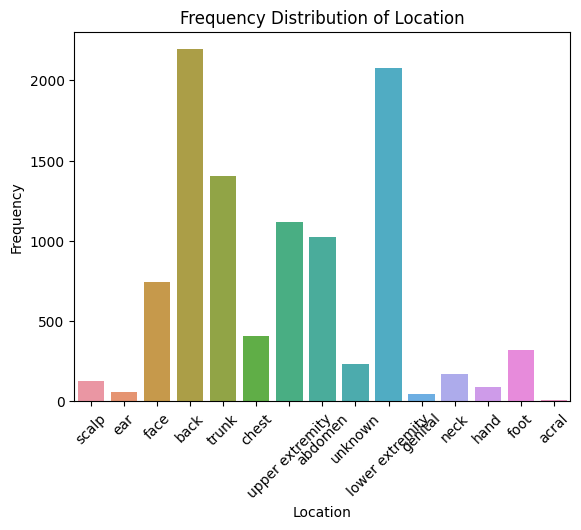

In [9]:
# 5. 각 location별 frequency 확인
sns.countplot(x = 'localization', data = data)
plt.xticks(rotation=45)
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Location')

---
### Main: data preprocessing & model fitting, training, evaluation 진행

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D , MaxPooling2D , BatchNormalization, Activation, Flatten ,  GlobalAveragePooling2D, Dense ,  Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping
import tensorflow as tf

2024-05-13 13:05:26.757471: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 13:05:26.757565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 13:05:26.839083: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
# 학습에 사용할 RGB type 데이터 불러오기
data_img = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
print('shape: ',data_img.shape)
print('column names: ',data_img.columns)

shape:  (10015, 2353)
column names:  Index(['pixel0000', 'pixel0001', 'pixel0002', 'pixel0003', 'pixel0004',
       'pixel0005', 'pixel0006', 'pixel0007', 'pixel0008', 'pixel0009',
       ...
       'pixel2343', 'pixel2344', 'pixel2345', 'pixel2346', 'pixel2347',
       'pixel2348', 'pixel2349', 'pixel2350', 'pixel2351', 'label'],
      dtype='object', length=2353)


In [12]:
from tensorflow.keras.applications import ResNet50

In [13]:
# Resnet50 model 준비
BATCH_SIZE = 128 # batch size를 너무 크게 잡는 것도 좋지 않지만, 
                # kaggle의 draft session에서의 cpu, ram, gpu 사용량 제한에 의해 최대한 학습 resource와 time을 줄이는 것이 중요해 이렇게 다소 높게 잡았습니다.

def model_resnet50(in_shape=(224, 224, 3), n_classes=7):
    input_tensor = Input(shape=in_shape)
    
    base_model = ResNet50(input_tensor=input_tensor, include_top=False, weights='imagenet')
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    x = Dense(128, activation='relu', name='fc1')(x)
    output = Dense(n_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
    
    return model

Shape of X : (46935, 28, 28, 3)
Shape of Y: (46935,)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Frequency Distribution of Classes')

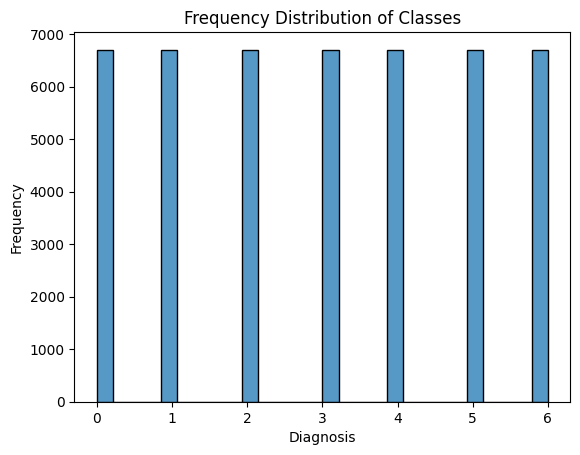

In [14]:
from imblearn.over_sampling import RandomOverSampler 
oversample = RandomOverSampler()

X_over = data_img.drop(columns = ['label'])
y_over = data_img['label'] #여기서 나중에 학습에 사용하기 위해 to_categorical 함수를 통한 one-hot encoding이 필요했으나, 빠져있다...? 그래서 밑의 code block에 일단 해놓았다. 실험해보자.

X_over,y_over  = oversample.fit_resample(X_over,y_over)
X_over = np.array(X_over).reshape(-1,28,28,3)
print('Shape of X :',X_over.shape)
print('Shape of Y:', y_over.shape)

sns.histplot(y_over)
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Classes')

In [15]:
import scipy
t = np.zeros([len(X_over), 32, 32, 3],dtype=np.float32)
for i in range(len(X_over)):
    t[i] = scipy.ndimage.zoom(X_over[i],32/28)
X_over = np.array(t).reshape(-1,32,32,3)
# X_over = vgg_preprocess(X_over)/255
X = X_over / 255
# image size를 128x128로 하여 정보 손실을 최대한 줄이고 싶었으나, 128x128의 preprocessing을 image size를 그것도 over sampling된 dataset에 하려고 하니 너무 용량이 커서 kaggle session이 버티지 못한다.
from tensorflow.keras.utils import to_categorical
# y = data_img['label']
y_over = to_categorical(y_over)
print('Shape of Y :',y_over.shape)
y = y_over

#data split 진행(train, test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2023)
X_tr, X_va, y_tr, y_va = train_test_split(X_train,y_train, test_size=0.2, random_state=2023)

print("preprocessing and data split complete.")

Shape of Y : (46935, 7)
preprocessing and data split complete.


In [16]:
print(X.shape)
print(y.shape)

(46935, 32, 32, 3)
(46935, 7)


In [18]:
# ImageDataGenerator를 통한 데이터불균형에 대한 균형맞추기 진행.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tr_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    horizontal_flip=True,
    rescale=1/255.0
)
va_generator = ImageDataGenerator(
    rescale=1/255.0
)

flow_tr_gen = tr_generator.flow(X_tr, y_tr, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = va_generator.flow(X_va, y_va, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
# model_1 = model_resnet50(in_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), n_classes=7)
model_1 = model_resnet50(in_shape=(32, 32, 3), n_classes=7)

model_1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model_1.fit(flow_tr_gen, epochs=30, 
                    validation_data=flow_val_gen,
                    batch_size = BATCH_SIZE,
                    shuffle=True,
                    callbacks=[rlr_cb, ely_cb]
                   )

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 23,850,887 (90.98 MB)

 Trainable params: 23,797,767 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/235 ━━━━━━━━━━━━━━━━━━━━ 4:06:01 63s/step - accuracy: 0.1250 - loss: 3.2485

I0000 00:00:1715605767.333738     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715605767.433880     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/235 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.3537 - loss: 1.9544

W0000 00:00:1715605804.620023     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.4295 - loss: 1.6882

W0000 00:00:1715605815.597191     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


235/235 ━━━━━━━━━━━━━━━━━━━━ 114s 218ms/step - accuracy: 0.4307 - loss: 1.6842 - val_accuracy: 0.1474 - val_loss: 6.6622 - learning_rate: 1.0000e-04
Epoch 2/30


W0000 00:00:1715605818.384327     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.7614 - loss: 0.6509 - val_accuracy: 0.1369 - val_loss: 34.2354 - learning_rate: 1.0000e-04
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.8491 - loss: 0.4146 - val_accuracy: 0.1369 - val_loss: 12.2000 - learning_rate: 1.0000e-04
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.8904 - loss: 0.2994 - val_accuracy: 0.1457 - val_loss: 9.5921 - learning_rate: 1.0000e-04
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.9149 - loss: 0.2298 - val_accuracy: 0.1366 - val_loss: 5.7396 - learning_rate: 1.0000e-04
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.9368 - loss: 0.1816 - val_accuracy: 0.1375 - val_loss: 3.4256 - learning_rate: 1.0000e-04
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.9471 - loss: 0.1486 - val_accuracy: 0.1399 - val_loss: 5.0006 - learning_rate: 1.0000e-04
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accur

In [20]:
# TEST DATASET에 대한 generator 진행 후 평가 진행.
test_generator = ImageDataGenerator(
    rescale=1/255.0
)
flow_test_gen = test_generator.flow(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)
model_1.evaluate(flow_test_gen)

74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9781 - loss: 0.0935


W0000 00:00:1715606333.382548     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.09848207980394363, 0.9768829345703125]

In [21]:
# CAM 모델 정의
cam_model  = Model(inputs=model_1.input,outputs=(model_1.layers[-3].output,model_1.layers[-1].output))
cam_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 23,850,887 (90.98 MB)

 Trainable params: 23,797,767 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [22]:
img = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
img = img.drop(columns = ['label'])
test_img = np.array(img.loc[0])
# 이전에 세팅한 input layer, image size 크기 32x32에 맞춰서 32/4로 세팅.
test_img = test_img.reshape(28,28,3)
test_img = scipy.ndimage.zoom(test_img,(32/28,32/28,1))
test_img = test_img.reshape(-1,32,32,3)
test_img_proc= test_img / 255

# from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
# test_img_proc= vgg_preprocess(test_img)/255

In [23]:
print(test_img_proc.shape)

(1, 32, 32, 3)


In [42]:
def show_cam(image_value, features, results):
  
    # there is only one image in the batch so we index at `0`
    features_for_img = features[0]
    prediction = np.argmax(results)

    # there is only one unit in the output so we get the weights connected to it
    gap_weights = model_1.layers[-1].get_weights()[0]
    class_activation_weights = gap_weights[:, prediction]
    
    print("features_for img shape: ", features_for_img.shape) # (2048,)
    print("class_actiavtion_weights shape: ", class_activation_weights.shape)# (128,)

    # upsample to the image size
    image_size = 32
    class_activation_features = scipy.ndimage.zoom(features_for_img.reshape(-1, 1), (image_size/4,image_size/4), order=2) # zoom은 배열 차원수 만큼 인수를 맞춰야 한다. 그리고 image 사이즈와 feature map 크기 만큼 수치를 주어야 한다.
    
    # reshape class_activation_features to (16384, 128)
    # 내적을 위해서는 위 zoom연산을 통해 up-sampling시킨 features에 대해 reshape을 주어서 weights와 차원수, 행렬 수를 통일시킬 필요가 있다.
    class_activation_features = class_activation_features.reshape(-1, 128)
    
    # reshape class_activation_weights to (128, 1)
    # weights또한 1차원인 상태로는 내적연산이 안되기 때문에 reshape을 통해 features와 통일시키기 위해 1개 차원을 증가시킨다.
    class_activation_weights = class_activation_weights.reshape(-1, 1)
    
    print("class activation features shape: ", class_activation_features.shape)
    
    # compute the intensity of each feature in the CAM
    # 각각의 feature들에 대한 CAM(Class Activation Map) 연산 진행.(내적 원리 활용, 강의 자료 및 강의 코드, 논문 등 참고)
    cam_output = np.dot(class_activation_features, class_activation_weights)

    # visualize the results
    plt.figure(figsize=(8, 8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
features shape:  (1, 2048)
features shape:  (1, 7)
features_for img shape:  (2048,)
class_actiavtion_weights shape:  (128,)
class activation features shape:  (1024, 128)


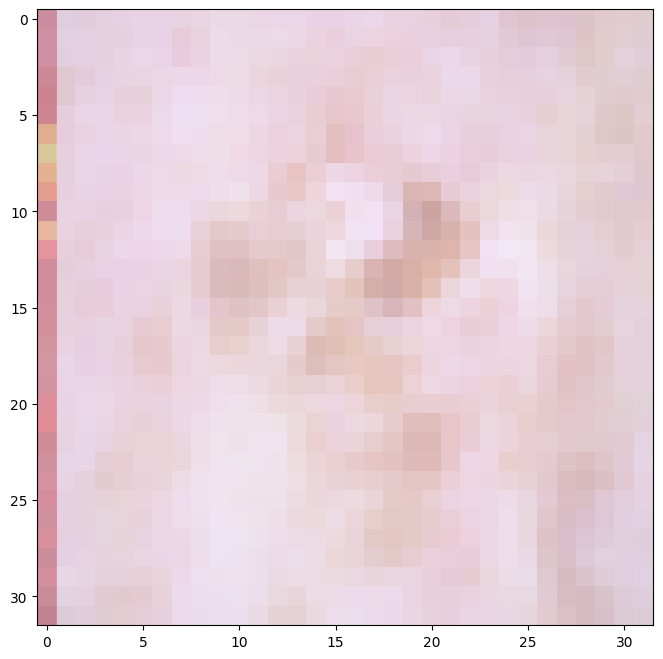

In [43]:
#cam_input =  np.expand_dims(test_img_proc, axis=0)
# CAM show 진행.
features,results = cam_model.predict(test_img_proc)
print("features shape: ", features.shape)
print("features shape: ", results.shape)
show_cam(test_img, features, results)


In [ ]:
print(features[0].shape)

In [ ]:
print(features.shape)